# Demo de un asistente RAG

## Pre-Procesamiento

Documento obtenido de https://gradientflow.substack.com/p/best-practices-in-retrieval-augmented

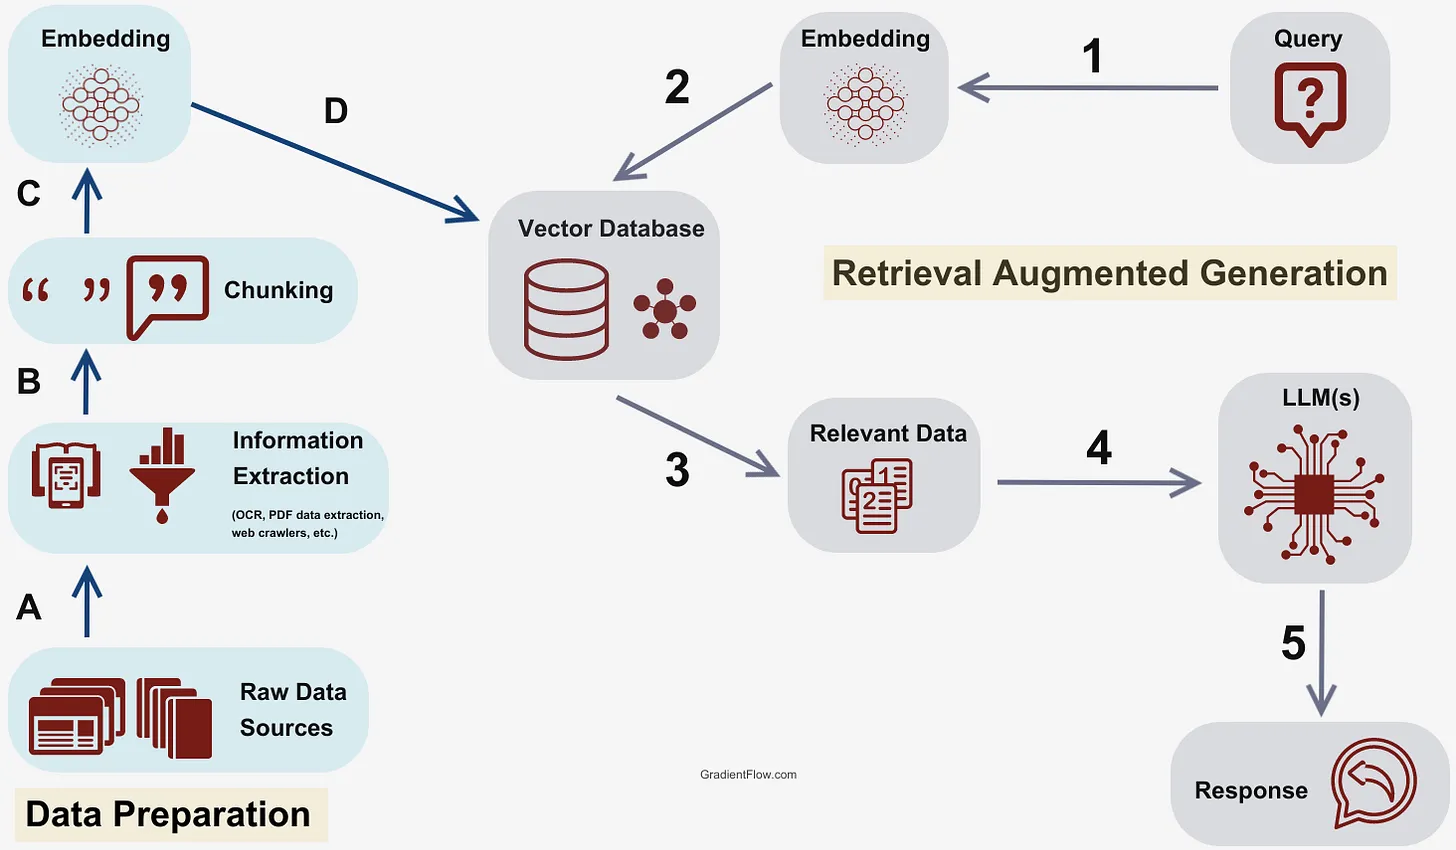

### Configuración

In [17]:
# Parser
from llama_index.core.node_parser import MarkdownNodeParser
from llama_index.core import SimpleDirectoryReader
from llama_parse import LlamaParse

# Core
from llama_index.core import Settings
from dotenv import load_dotenv
import os

# Vector Stores
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex

# Retriever
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import StorageContext, get_response_synthesizer

# Custom Template
from llama_index.core import PromptTemplate

# Clients
from llama_index.postprocessor.cohere_rerank import CohereRerank
from llama_index.embeddings.cohere import CohereEmbedding
from llama_index.llms.anthropic import Anthropic
from qdrant_client import QdrantClient

### Variables de entorno

In [18]:
load_dotenv()
COHERE_API_KEY = os.environ.get("COHERE_API_KEY")
QDRANT_CLUSTER = os.environ.get("QDRANT_CLUSTER")
QDRANT_API_KEY = os.environ.get("QDRANT_API_KEY")
QDRANT_COLLECTION = os.environ.get("QDRANT_COLLECTION")
LLAMACLOUD_API_KEY = os.environ.get("LLAMACLOUD_API_KEY")

In [19]:
llm = Anthropic(model="claude-3-haiku-20240307") # La API Key se lee directamente de la variable ANTHROPIC_API_KEY
cohere_rerank = CohereRerank(api_key=COHERE_API_KEY, top_n=2) # top_n: número de documentos que retorna el reranker
cohere_embed_model = CohereEmbedding(
  cohere_api_key=COHERE_API_KEY, # La prueba gratis tiene un límite de 1000 llamadas al mes	
  model_name="embed-multilingual-v3.0",
  input_type="search_document",
)
client = QdrantClient(url=QDRANT_CLUSTER, api_key=QDRANT_API_KEY)

In [5]:
Settings.embed_model = cohere_embed_model
Settings.chunk_size = 1024
Settings.llm = llm
Settings.transformations = [MarkdownNodeParser()]

### Procesar de documentos

In [6]:
import nest_asyncio
nest_asyncio.apply() # Tenemos que añadir esta línea para que funcione en el jupyter notebook

llama_parser = LlamaParse(api_key=LLAMACLOUD_API_KEY, result_type="markdown")

file_extractor = { ".pdf": llama_parser } # Podemos añadir más extractores de archivos aquí

documents = SimpleDirectoryReader("./data", file_extractor=file_extractor).load_data()

# Excluimos los metadatos de los documentos que no queremos que se indexen
for d in documents:
  d.excluded_embed_metadata_keys = ["file_path", "file_type", "file_size", "last_modified_date"]
  d.excluded_llm_metadata_keys = ["file_path", "file_type", "file_size", "last_modified_date"]

Started parsing the file under job_id 638d2bcb-89ec-4592-bae1-02639894719d
.

In [20]:
documents[0]

Document(id_='3531b1cf-08df-437b-81e5-b55fdec6927a', embedding=None, metadata={'file_path': '/home/madauy/code/youtube/rag-demo/data/Modelos Porsche.pdf', 'file_name': 'Modelos Porsche.pdf', 'file_type': 'application/pdf', 'file_size': 4308442, 'creation_date': '2024-06-03', 'last_modified_date': '2024-06-03'}, excluded_embed_metadata_keys=['file_path', 'file_type', 'file_size', 'last_modified_date'], excluded_llm_metadata_keys=['file_path', 'file_type', 'file_size', 'last_modified_date'], relationships={}, text='Modelos Porsche\nFascinación por el automóvil deportivo\n---\n|El sueño de conducir|911 GT3|\n|---|---|\n|un deportivo|Taycan|\n|Códigos Porsche|Panamera|\n|718 Cayman y 718 Boxster|Macan|\n|718 Cayman GT4|Cayenne|\n|718 Cayman GT4 RS|Porsche Exclusive Manufaktur|\n|718 Spyder|Porsche Tequipment y Porsche Car Configurator|\n|911 Carrera y 911 Targa| |\n|911 Turbo|Datos técnicos|\n---\n# El sueño de conducir un deportivo.\n\nPara alcanzar un gran sueño hay que luchar. Y también

### Creación de embeddings

In [8]:
vector_store = QdrantVectorStore(
  collection_name=QDRANT_COLLECTION,
  client=client,
  enable_hybrid=True,
  batch_size=20,
)

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 104335.92it/s]


In [9]:
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(documents=documents, storage_context=storage_context)

## Asistente

In [21]:
index = VectorStoreIndex.from_vector_store(vector_store=vector_store)

In [11]:
qa_prompt_tmpl = (
    "A continuación se encuentra la información de contexto.\n"
    "-------------------------------"
    "{context_str}\n"
    "-------------------------------"
    "Dada la información de contexto y sin conocimiento previo,"
    "responde a la consulta. Por favor, sé conciso y completo.\n"
    "Si el contexto no contiene una respuesta a la consulta,"
    "responde con \"¡No lo sé!\"."
    "Consulta: {query_str}\n"
    "Respuesta: "
)
qa_prompt = PromptTemplate(qa_prompt_tmpl)

In [12]:
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=3, # Cuantos documentos devuelve por similitud
    sparse_top_k=10, # Cuantos documentos devuelve por sparse (keyword match o búsqueda exácta)
    vector_store_query_mode="hybrid",
)

response_synthesizer = get_response_synthesizer(
    text_qa_template=qa_prompt,
    response_mode="compact",
)

query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[cohere_rerank],
)

In [23]:
result = query_engine.query("Consumo eléctrico combinado Taycan Sport Turismo")
result.response

'Según la información proporcionada en el contexto, el consumo eléctrico combinado del Taycan Sport Turismo es:\n\n- Batería de altas prestaciones (Performance Battery): 24,2 - 20,2 kWh/100 km\n- Batería de altas prestaciones Plus (Performance Battery Plus): 24,2 - 20,2 kWh/100 km'